In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/home/wanhr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_ip = "10.215.173.1"
dl_pkts = np.zeros([0, 3])
ul_pkts = np.zeros([0, 3])

for i in [2]:
  filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_{}.csv".format(i)

  df = load_csv(filename)
  # stats_src_ip(df)
  # stats_dst_ip(df)
  dl_data = extract_dl_pkt_interval_time(df, local_ip)
  ul_data = extract_ul_pkt_interval_time(df, local_ip)
  dl_pkts = np.concatenate((dl_pkts, dl_data), axis=0)
  ul_pkts = np.concatenate((ul_pkts, ul_data), axis=0)
  print(dl_pkts.shape)
  print(ul_pkts.shape)
  # dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
  # ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

FONT_SIZE = 35
plt.rcParams["font.size"] = FONT_SIZE

(4092384, 3)
(562975, 3)


In [3]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=1000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=1000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

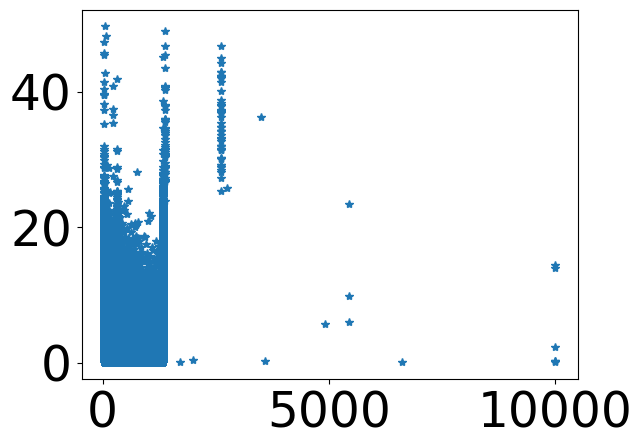

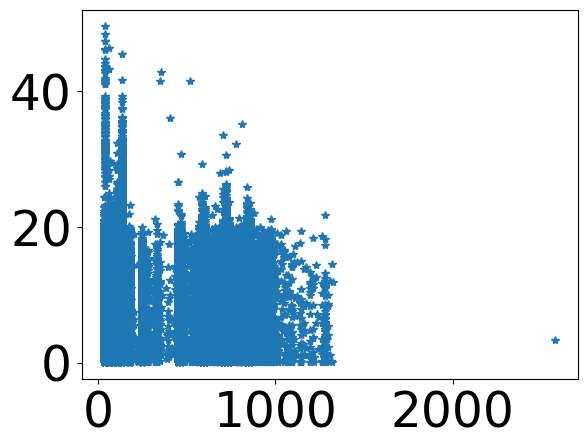

In [4]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

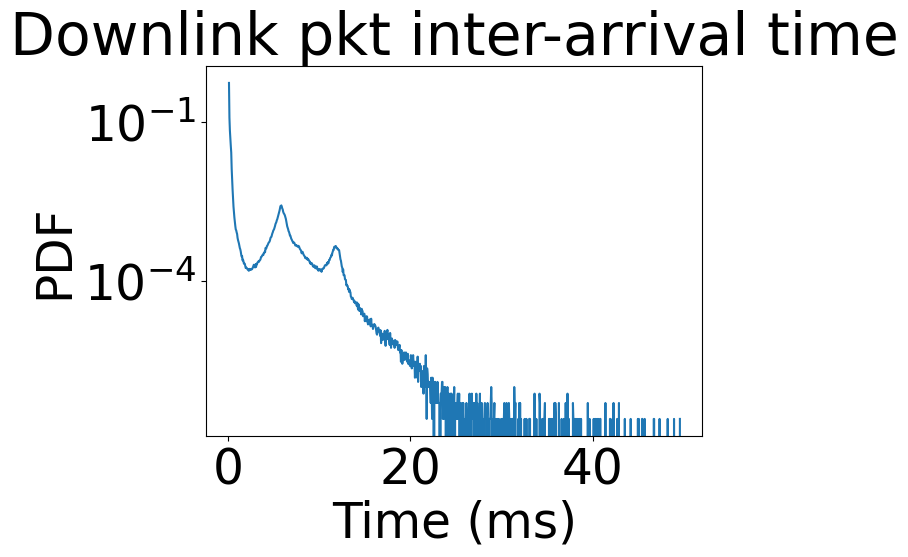

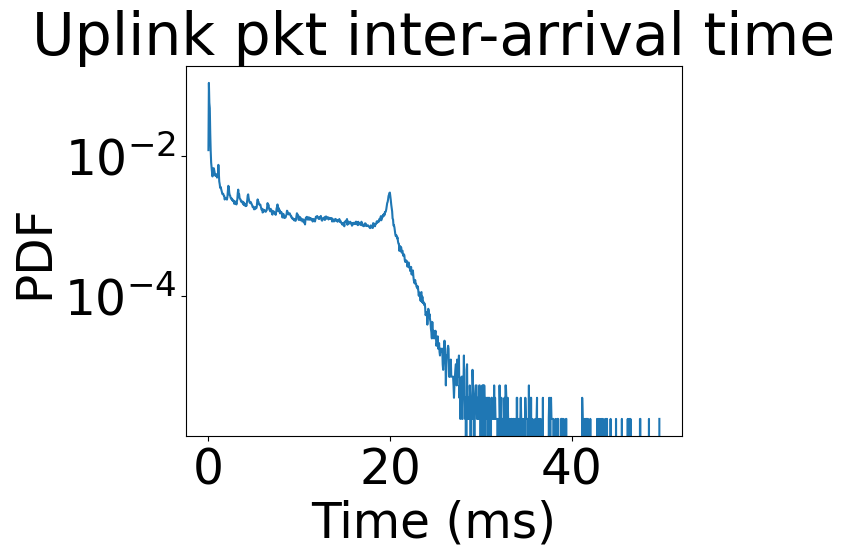

In [5]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.title("Uplink pkt inter-arrival time")

plt.show()

In [6]:
train = torch.tensor(ul_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

/home/wanhr/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/wanhr/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:905: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


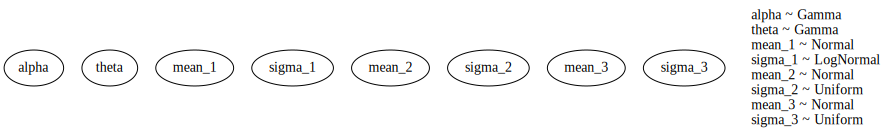

In [7]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.05))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.05))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    mean_3 = pyro.sample("mean_3", dist.Normal(20, 2))
    sigma_3 = pyro.sample("sigma_3", dist.Uniform(0., 0.05))
    gaussian_3 = dist.Normal(mean_3, sigma_3)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.6, 0.1, 0.1, 0.2]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    gaussian_samp_3 = gaussian_3.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2 + y[3] * gaussian_samp_3

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [8]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    mean_3_loc = pyro.param('mean_3_loc', lambda: torch.tensor(12. ))
    sigma_3_loc = pyro.param('sigma_3_loc', lambda: torch.tensor(0.))
    mean_3 = pyro.sample('mean_3', dist.Normal(mean_3_loc, torch.tensor(0.05)))
    sigma_3 = pyro.sample('sigma_3', dist.LogNormal(sigma_3_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2, 'mean_3': mean_3, 'sigma_3': sigma_3}

/home/wanhr/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


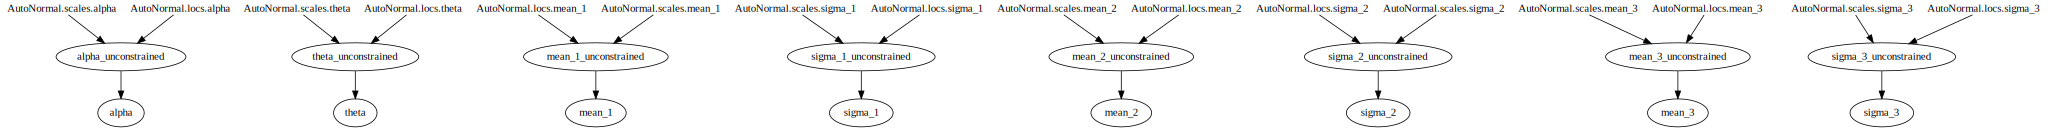

In [9]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

pyro.render_model(auto_guide, model_args=(pkt_size, pkt_interval), render_params=True)

In [10]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Step: 0, Elbo loss: 89.02859248034656
Step: 100, Elbo loss: 61.08130814880133
Step: 200, Elbo loss: 43.138689428567886
Step: 300, Elbo loss: 28.46030181646347
Step: 400, Elbo loss: 17.31311995862052
Step: 500, Elbo loss: 22.528501257300377
Step: 600, Elbo loss: 13.96432338654995
Step: 700, Elbo loss: 10.565150212496519
Step: 800, Elbo loss: 1.5241491869091988
Step: 900, Elbo loss: 9.009950548410416
Step: 1000, Elbo loss: 4.432120241224766
Step: 1100, Elbo loss: 0.8624278735369444
Step: 1200, Elbo loss: 3.1639964506030083
Step: 1300, Elbo loss: 1.7264000494033098
Step: 1400, Elbo loss: 2.686157926917076
Step: 1500, Elbo loss: -0.8744365014135838
Step: 1600, Elbo loss: 0.6716193780303001
Step: 1700, Elbo loss: -0.11886935122311115
Step: 1800, Elbo loss: 0.20349254459142685
Step: 1900, Elbo loss: -1.4381008259952068
Step: 2000, Elbo loss: 0.5225410759449005
Step: 2100, Elbo loss: 0.6676213927567005
Step: 2200, Elbo loss: 0.5517556648701429
Step: 2300, Elbo loss: 1.0359929651021957
Step: 2

Text(0, 0.5, 'ELBO loss')

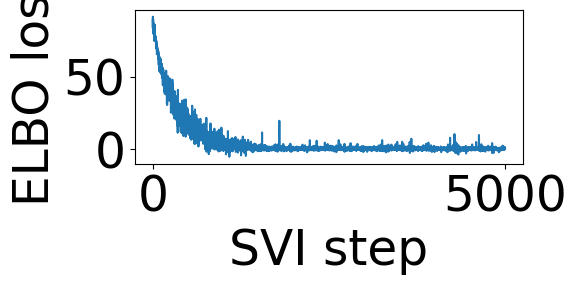

In [11]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

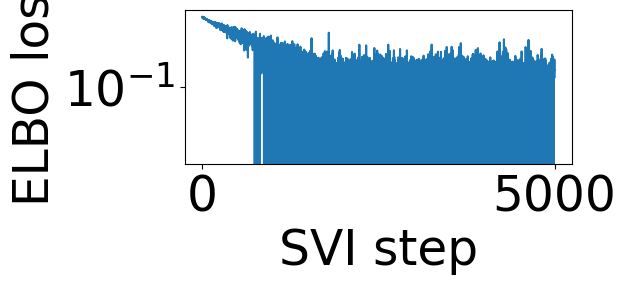

In [12]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.5886351
AutoNormal.scales.alpha 1.0210662
AutoNormal.locs.theta -0.5216641
AutoNormal.scales.theta 1.0032904
AutoNormal.locs.mean_1 5.152076
AutoNormal.scales.mean_1 1.8627211
AutoNormal.locs.sigma_1 -0.031170849
AutoNormal.scales.sigma_1 0.04965516
AutoNormal.locs.mean_2 12.067375
AutoNormal.scales.mean_2 1.9356859
AutoNormal.locs.sigma_2 -0.0872314
AutoNormal.scales.sigma_2 1.8363713
AutoNormal.locs.mean_3 19.998938
AutoNormal.scales.mean_3 1.8969173
AutoNormal.locs.sigma_3 0.012991989
AutoNormal.scales.sigma_3 1.7894623


In [14]:
res_svi = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  gaussian_samp_3 = dist.Normal(svi_samples['mean_3'][0], svi_samples['sigma_3'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.6, 0.1, 0.1, 0.2]))
  y = cat_dist.sample()
  res_svi.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2 + y[3] * gaussian_samp_3)
  
print(res_svi)

[tensor(0.5443), tensor(0.5028), tensor(0.0194), tensor(20.9784), tensor(0.1352), tensor(20.4813), tensor(20.2343), tensor(20.2049), tensor(18.4018), tensor(20.9881), tensor(19.1757), tensor(17.2766), tensor(9.8368), tensor(1.2385), tensor(3.0854), tensor(1.6119), tensor(1.2710), tensor(4.1388), tensor(1.0672), tensor(10.6952), tensor(0.1446), tensor(12.7412), tensor(10.7494), tensor(2.2189), tensor(0.0560), tensor(0.4251), tensor(5.7164), tensor(17.0831), tensor(22.5284), tensor(0.5026), tensor(17.6368), tensor(19.9607), tensor(21.8047), tensor(1.3944), tensor(8.1508), tensor(11.9946), tensor(1.0610), tensor(0.1899), tensor(0.0829), tensor(0.1189), tensor(0.1052), tensor(0.5840), tensor(10.5874), tensor(4.3487), tensor(19.4916), tensor(11.0504), tensor(12.0321), tensor(1.1896), tensor(19.3521), tensor(3.7023), tensor(0.4770), tensor(3.8082), tensor(4.7440), tensor(18.5750), tensor(14.2569), tensor(21.2630), tensor(11.0839), tensor(1.8535), tensor(11.9486), tensor(0.1669), tensor(6.086

In [15]:
res_svi = np.array(res_svi)

res_count_svi, res_bins_count_svi = np.histogram(res_svi, bins=1000) 
res_pdf_svi = res_count_svi / sum(res_count_svi) 
res_cdf_svi = np.cumsum(res_pdf_svi) 

In [16]:
def guide_map(pkt_size, pkt_interval=None):
  alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.unit_interval)
  alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

  theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

  mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
  mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
  sigma_1 = pyro.sample('sigma_1', dist.Uniform(0, torch.tensor(0.005)))

  mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
  mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
  sigma_2 = pyro.sample('sigma_2', dist.Uniform(0, torch.tensor(0.005)))

  mean_3_loc = pyro.param('mean_3_loc', lambda: torch.tensor(20. ))
  mean_3 = pyro.sample('mean_3', dist.Normal(mean_3_loc, torch.tensor(0.05)))
  sigma_3 = pyro.sample('sigma_3', dist.Uniform(0, torch.tensor(0.005)))

  # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
  #                       constraint=constraints.positive)
  # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
  # y = pyro.sample('y', cat)

  return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
          'mean_2': mean_2, 'sigma_2': sigma_2, 'mean_3': mean_3, 'sigma_3': sigma_3}

In [17]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide_map, adam, elbo)

Step: 0, Elbo loss: 5917.483767688274
Step: 100, Elbo loss: 9136.591245841235
Step: 200, Elbo loss: 8548.090874403715
Step: 300, Elbo loss: 5852.393249630928
Step: 400, Elbo loss: 11244.42489507189
Step: 500, Elbo loss: 16972.016986805946
Step: 600, Elbo loss: 15847.257699429989
Step: 700, Elbo loss: 14665.89183947444
Step: 800, Elbo loss: 5709.2015780471265
Step: 900, Elbo loss: 6342.733859747648
Step: 1000, Elbo loss: 8237.1138952896
Step: 1100, Elbo loss: 7531.0821547061205
Step: 1200, Elbo loss: 7897.698228359222
Step: 1300, Elbo loss: 10303.74781653285
Step: 1400, Elbo loss: 7407.56359398365
Step: 1500, Elbo loss: 10678.638429701328
Step: 1600, Elbo loss: 7307.394086241722
Step: 1700, Elbo loss: 5649.805047526956
Step: 1800, Elbo loss: 6283.20340692997
Step: 1900, Elbo loss: 5680.196544706821
Step: 2000, Elbo loss: 10431.375357434154
Step: 2100, Elbo loss: 6885.680324733257
Step: 2200, Elbo loss: 6724.9052421450615
Step: 2300, Elbo loss: 13221.374988034368
Step: 2400, Elbo loss: 1

Text(0, 0.5, 'ELBO loss')

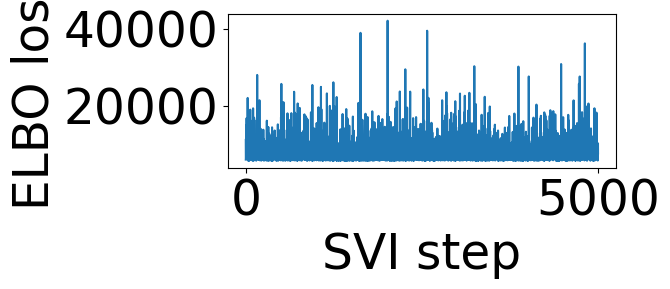

In [18]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide_map, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

In [19]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

alpha_alpha 0.9999999
alpha_theta 0.9999863
theta_alpha 0.9999999
theta_theta 0.99999416
mean_1_loc 5.028744
mean_2_loc 12.032603
mean_3_loc 20.003473


In [21]:
res = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=guide_map, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  gaussian_samp_3 = dist.Normal(svi_samples['mean_3'][0], svi_samples['sigma_3'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.6, 0.1, 0.1, 0.2]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2 + y[3] * gaussian_samp_3)
  
print(res)

[tensor(20.1104), tensor(20.0208), tensor(8.1510), tensor(12.0310), tensor(12.0912), tensor(1.4932), tensor(5.0613), tensor(0.0637), tensor(1.6849), tensor(20.0577), tensor(12.0437), tensor(2.7573), tensor(5.7078), tensor(98.6301), tensor(12.0469), tensor(4.2080), tensor(0.8316), tensor(0.2417), tensor(0.8799), tensor(20.0927), tensor(1.8366), tensor(1.7721), tensor(20.0916), tensor(1.5042), tensor(4.9862), tensor(1.0896), tensor(0.2044), tensor(19.9638), tensor(0.6395), tensor(0.0243), tensor(12.0494), tensor(0.7459), tensor(19.9646), tensor(4.9950), tensor(12.0219), tensor(1.3457), tensor(13.8317), tensor(0.6509), tensor(0.2363), tensor(20.0016), tensor(19.9767), tensor(19.9992), tensor(2.0641), tensor(3.1657), tensor(20.0181), tensor(51.7771), tensor(5.0315), tensor(19.8653), tensor(2.5654), tensor(3.4432), tensor(0.2058), tensor(43.2743), tensor(0.0783), tensor(2.9174), tensor(0.2447), tensor(0.0813), tensor(0.3948), tensor(0.4437), tensor(1.5892), tensor(5.1026), tensor(19.9499), 

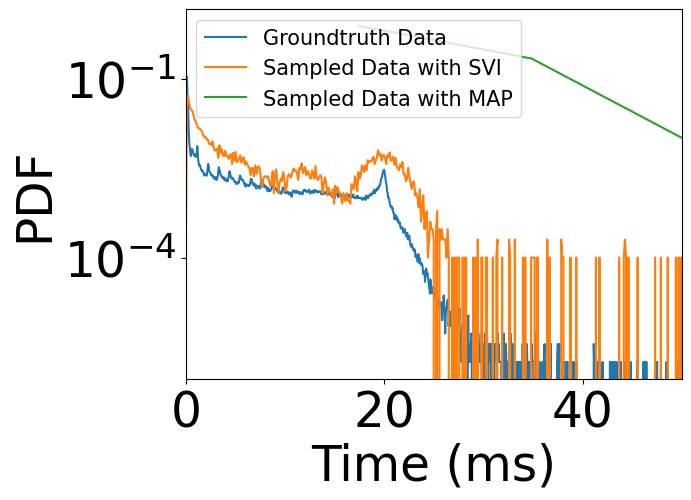

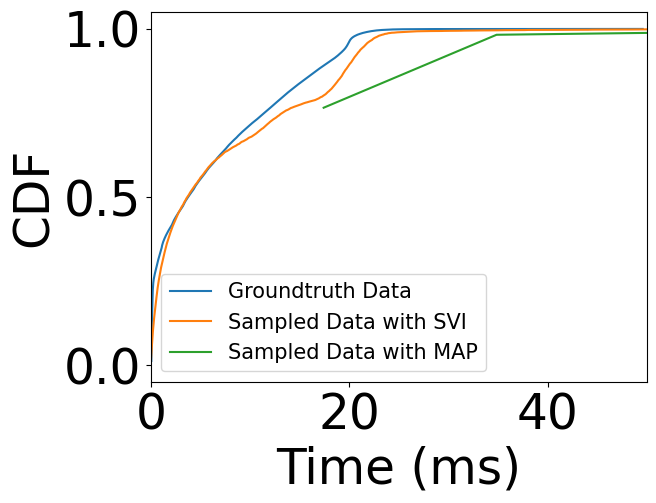

In [22]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=1000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf, label="Groundtruth Data")
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")

# plt.figure()
plt.plot(res_bins_count_svi[1:], res_pdf_svi, label="Sampled Data with SVI")
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")

# plt.figure()
plt.plot(res_bins_count[1:], res_pdf, label="Sampled Data with MAP")
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.legend(prop={'size': 15})

plt.figure()
plt.plot(ul_bins_count[1:], ul_cdf, label="Groundtruth Data")
# plt.yscale("log")

# plt.figure()
plt.plot(res_bins_count_svi[1:], res_cdf_svi, label="Sampled Data with SVI")
# plt.yscale("log")
plt.plot(res_bins_count[1:], res_cdf, label="Sampled Data with MAP")

plt.xlim([0, 50])
plt.xlabel("Time (ms)")
plt.ylabel("CDF")

plt.legend(prop={'size': 15})

plt.show()